# Processing CSV files

In [1]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import data_processing as dp
import plotly.graph_objects as go
import plot_formatting as pfg
import seaborn as sns

pd.options.display.float_format = '{:.4f}'.format

datasets = ['POS', 'BARO']
data_folder = 'impact_analysis/'
normal = 'normal'
stale_data = 'stale_data'
default_data = 'default_data'
erroneous_data = 'erroneous_data'
absent_data = 'absent_data'
file_name_a = 'straight'
file_name_b = '_no_attack_'

normal_traces_dict = dict()
for i in range(0,11):
    if i == 0:
        normal_traces_dict[file_name_a+str(i)] = dp.load_csv_files(datasets,imu=data_folder+normal,csv_file=file_name_a+file_name_b)
    else:
        normal_traces_dict[file_name_a+str(i)] = dp.load_csv_files(datasets,imu=data_folder+normal,csv_file=file_name_a+str(i)+file_name_b)
        
attack_start = 101740954
attack_stops = 102741387
               

In [2]:
from math import cos, sqrt
columns = ['TimeUS','x','y','Alt']
zero_df = normal_traces_dict['straight0']['POS']
lat0 = zero_df['Lat'].values[0]
long0 = zero_df['Lng'].values[0]
phi = lat0
positions_dict = dict()
# Convert latitude and longitude to meters
lat2meters = 111132.92 - 559.82*cos(2*phi) + 1.175*cos(4*phi) - 0.0023*cos(6*phi)
long2meters = 111412.84*cos(phi) -93.5*cos(3*phi) +0.118*cos(5*phi)
straight = 'straight'
numbers = range(0,11)
for mission in numbers:
    normal_traces_dict[straight+str(mission)]['POS']['x'] = normal_traces_dict[straight+str(mission)]['POS']['Lat'].add(-lat0)*(-lat2meters)
    normal_traces_dict[straight+str(mission)]['POS']['y'] = normal_traces_dict[straight+str(mission)]['POS']['Lng'].add(-long0)*long2meters


In [3]:
average_position_df = normal_traces_dict[straight+str(0)]['POS'][columns]
for mission in range(1,11):
   average_position_df =  average_position_df.add(normal_traces_dict[straight+str(mission)]['POS'][columns],axis=0)
average_position_df = average_position_df/11
average_position_df['Alt'] = average_position_df['Alt'] - 584.0600
average_position_df.describe()

average_position_df = average_position_df[average_position_df['TimeUS']>=101740954]

In [4]:
import numpy as np
def load_attack_traces(path):
    attack_data_traces_dict = dict()
    for i in range(0,11):
        if i == 0:
            attack_data_traces_dict[file_name_a+str(i)] = dp.load_csv_files(datasets,imu=path,csv_file=file_name_a+file_name_b)
        else:
            attack_data_traces_dict[file_name_a+str(i)] = dp.load_csv_files(datasets,imu=path,csv_file=file_name_a+str(i)+file_name_b)
        attack_data_traces_dict[file_name_a+str(i)]['POS'] = attack_data_traces_dict[file_name_a+str(i)]['POS'][attack_data_traces_dict[file_name_a+str(i)]['POS']['TimeUS']>=101740954]

        if '1Hz' in path:
            attack_data_traces_dict[file_name_a+str(i)]['MSG'] = attack_data_traces_dict[file_name_a+str(i)]['MSG'][attack_data_traces_dict[file_name_a+str(i)]['MSG']['Message'].str.contains('EKF Variance|Compass error', na=False)]
        else:
            if attack_data_traces_dict[file_name_a+str(i)]['MSG']['Message'].str.contains('SIM Hit ground|EKF Failsafe|Reached final waypoint 1', na=False).any(): 
                attack_data_traces_dict[file_name_a+str(i)]['MSG'] = attack_data_traces_dict[file_name_a+str(i)]['MSG'][attack_data_traces_dict[file_name_a+str(i)]['MSG']['Message'].str.contains('SIM Hit ground|EKF Failsafe|Reached final waypoint 1', na=False)]  
            else:
                attack_data_traces_dict[file_name_a+str(i)]['MSG'] = attack_data_traces_dict[file_name_a+str(i)]['MSG'][attack_data_traces_dict[file_name_a+str(i)]['MSG']['Message'].str.contains('Attack Stops')]
    return attack_data_traces_dict
    
    

def transform_traces(attack_data_traces_dict):
    # Convert latitude and longitude to meters
    lat2meters = 111132.92 - 559.82*cos(2*phi) + 1.175*cos(4*phi) - 0.0023*cos(6*phi)
    long2meters = 111412.84*cos(phi) -93.5*cos(3*phi) +0.118*cos(5*phi)
    straight = 'straight'
    numbers = range(0,11)
    for mission in numbers:
        attack_data_traces_dict[straight+str(mission)]['POS']['x'] = attack_data_traces_dict[straight+str(mission)]['POS']['Lat'].add(-lat0)*(-lat2meters)
        attack_data_traces_dict[straight+str(mission)]['POS']['y'] = attack_data_traces_dict[straight+str(mission)]['POS']['Lng'].add(-long0)*long2meters
        attack_data_traces_dict[straight+str(mission)]['POS']['Alt'] = attack_data_traces_dict[straight+str(mission)]['POS']['Alt']- 584.0600
    return attack_data_traces_dict

def compute_distances_and_describe_traces(average_position_df,attack_data_traces_dict):
    columns = ['x','y','Alt']
    distances = {}
    for mission in numbers:
        distances[straight+str(mission)] = np.sqrt((average_position_df[columns] - 
                                                    attack_data_traces_dict[straight+str(mission)]['POS'][columns])**2)
        distances[straight+str(mission)]['TimeUS'] = average_position_df['TimeUS']
        #print(distances[straight+str(mission)].describe())
    return distances

def compute_distances_until_failsafe(average_position_df,attack_data_traces_dict):
    columns = ['x','y','Alt']
    distances = {}
    for mission in numbers:
        distances[straight+str(mission)] = np.sqrt((average_position_df[columns] - 
                                                    attack_data_traces_dict[straight+str(mission)]['POS'][columns][attack_data_traces_dict[straight+str(mission)]['POS']['TimeUS']<=attack_data_traces_dict[straight+str(mission)]['MSG']['TimeUS'].min()])**2)
        distances[straight+str(mission)]['TimeUS'] = average_position_df['TimeUS']
        #print(distances[straight+str(mission)].describe())
    return distances

def compute_average_distance(distances):
    average_distance_df = distances[straight+str(0)][columns]
    for mission in numbers:
        average_distance_df =  average_distance_df.add(distances[straight+str(mission)],axis=0)
    average_distance_df = average_distance_df/11
    return average_distance_df

def compute_cumsum(distances):
    distances_sum = pd.DataFrame(columns = [['x','y','Alt']], data = distances[straight+str(0)][['x','y','Alt']].sum().values.reshape(1,-1))

    for mission in numbers:
        distances_sum = pd.concat([distances_sum, pd.DataFrame(columns = [['x','y','Alt']], data = distances[straight+str(mission)][['x','y','Alt']].sum().values.reshape(1,-1))])
        
    distances_sum_mean, distances_sum_std = distances_sum.mean(), distances_sum.std()
    return distances_sum_mean,distances_sum_std

def compute_max_deviation(distances):
    distances_maximums = pd.DataFrame(columns = [['x','y','Alt']], data = distances[straight+str(0)][['x','y','Alt']].max().values.reshape(1,-1))

    for mission in numbers:
        distances_maximums = pd.concat([distances_maximums, pd.DataFrame(columns = [['x','y','Alt']], data = distances[straight+str(mission)][['x','y','Alt']].max().values.reshape(1,-1))])
        
    distances_max, distances_min, distances_max_mean, distances_max_std = distances_maximums.max(), distances_maximums.min(), distances_maximums.mean(), distances_maximums.std()
    return  distances_max, distances_min, distances_max_mean, distances_max_std

def compute_time_stats(time_vector):
    return np.array(time_vector).mean(), np.array(time_vector).std()
   
def plot(average_position_df,attack_data_traces_dict,x_axis,y_axis):
    fig2 = go.Figure()

    # include mission path
    fig2.add_trace(go.Scatter(x=average_position_df[::100][x_axis], y=average_position_df[::100][y_axis],
                            mode='lines+markers',
                            name='Planned',
                            line=dict(dash='dash', color='black')))



    for ix in numbers:
        
        fig2.add_trace(go.Scatter(x=attack_data_traces_dict[straight+str(ix)]['POS'][x_axis][::100], y=attack_data_traces_dict[straight+str(ix)]['POS'][y_axis][::100],
                                        mode='lines+markers',
                                        name= str(ix))
                                        # line=dict(color=colorset[ix]))
                    )



    # beautify plots
    fig2 = pfg.beautify_plot(fig2)
    title_size=40
    text_size=18



    fig2['layout'].update(width=800, height=400, font=dict(size=text_size))


    fig2['layout']['legend'].update(orientation='h',
                                    x=0.03,
                                    y=1.25,
                                    )


    fig2.show()

def plot_distances(average_position_df,attack_data_traces_dict,x_axis,y_axis):
    fig2 = go.Figure()

    # include mission path
    fig2.add_trace(go.Scatter(x=average_position_df[::100][x_axis], y=average_position_df[::100][y_axis],
                            mode='lines+markers',
                            name='Planned',
                            line=dict(dash='dash', color='black')))



    for ix in numbers:
        
        fig2.add_trace(go.Scatter(x=attack_data_traces_dict[straight+str(ix)][x_axis][::100], y=attack_data_traces_dict[straight+str(ix)][y_axis][::100],
                                        mode='lines+markers',
                                        name= str(ix))
                                        # line=dict(color=colorset[ix]))
                    )



    # beautify plots
    fig2 = pfg.beautify_plot(fig2)
    title_size=40
    text_size=18



    fig2['layout'].update(width=800, height=400, font=dict(size=text_size))


    fig2['layout']['legend'].update(orientation='h',
                                    x=0.03,
                                    y=1.25,
                                    )


    fig2.show()
    
def count_failsafes(data): #count logs where the first filtered event is a failsafe (the other possible event is hit ground)
    failsafes = 0
    crashes = 0 
    recovered = 0
    crash_times = []
    failsafe_times = []
    for num in numbers:
        #print(data[straight+str(num)]['MSG']['Message'].values)
        try:
            if 'Failsafe' in data[straight+str(num)]['MSG']['Message'].values[0]:
                failsafes = failsafes + 1
                attack_detection = data[straight+str(num)]['MSG']['TimeUS'].values[0]
                time_to_detect = (attack_detection - attack_start)*1e-6
                failsafe_times = failsafe_times + [time_to_detect]
                #print(attack_detection-attack_start)
                #print(failsafe_times)
                
        except:
            pass
        try:
            message_index = 0
            for string in data[straight+str(num)]['MSG']['Message'].values:
                #print(string)
                if 'SIM Hit ground' in string:
                    string = string.replace('SIM Hit ground at ', '')
                    value = float(string.replace(' m/s',''))
                    if value > 0.5: #expected landing velocity in default ardupilot config
                        crashes =  crashes + 1
                        crash_ground = data[straight+str(num)]['MSG']['TimeUS'].values[message_index]
                        time_to_crash = (crash_ground - attack_start)*1e-6
                        crash_times = crash_times + [time_to_crash]
                        #print(crash_times)
                if ': Attack Stops' in string:
                    crashes =  crashes + 1
                    crash_ground = data[straight+str(num)]['POS']['TimeUS'].values[
                                    (data[straight+str(num)]['POS']['Alt'].astype(float) < 0) & 
                                    (data[straight+str(num)]['POS']['TimeUS'] > attack_start)
                                    ]
                    time_to_crash = (crash_ground[0] - attack_start)*1e-6
                    crash_times = crash_times + [time_to_crash]
                if  'Reached final waypoint 1' in string:
                    recovered = recovered + 1
                message_index = message_index + 1
        except:
            pass
    print(failsafes, crashes, recovered, failsafe_times, crash_times)
    d = {'failsafe trigger time': failsafe_times}
    dataframe = pd.DataFrame(data=d)
    sns.violinplot(y = dataframe['failsafe trigger time'])
    
#     d = {'crash times': crash_times}
#     dataframe = pd.DataFrame(data=d)
#     sns.violinplot(x = dataframe['crash times'])
        
    return failsafes/11 * 100, crashes/11 * 100, recovered/11 * 100, failsafe_times, crash_times

def data_analysis(traces_dict):
    transformed_traces_dict = transform_traces(traces_dict)
    distances = compute_distances_and_describe_traces(average_position_df,transformed_traces_dict)
    distances_failsafe = compute_distances_until_failsafe(average_position_df,transformed_traces_dict)
    failsafes, crashes, recovered, failsafe_times, crash_times = count_failsafes(traces_dict)
    try:
        failsafe_mean, failsafe_std = compute_time_stats(failsafe_times)
    except:
        print('No failsafe')
    try:
        crash_mean, crash_std = compute_time_stats(crash_times)
    except:
        print('No Crashes')
    dist_mean, dist_std = compute_cumsum(distances)
    dist_max_max, dist_max_min, dist_max_mean, dist_max_std = compute_max_deviation(distances)
    dist_mean_f, dist_std_f = compute_cumsum(distances_failsafe)
    dist_max_max_f, dist_max_min_f, dist_max_mean_f,dist_max_std_f = compute_max_deviation(distances_failsafe)
    return distances, distances_failsafe, failsafes, crashes, recovered, failsafe_times, crash_times, failsafe_mean, failsafe_std, crash_mean, crash_std, dist_mean, dist_std,  dist_max_mean, dist_max_std, dist_mean_f, dist_std_f, dist_max_max_f, dist_max_min_f, dist_max_mean_f, dist_max_std_f

def add_line_to_results_df(results, attack, failsafes, crashes, recovered, failsafe_mean, failsafe_std, crash_mean, crash_std, dist_mean, dist_std, dist_max_mean, dist_max_std, dist_mean_f, dist_std_f, dist_max_max_f, dist_max_min_f, dist_max_mean_f, dist_max_std_f):
    results.loc[attack] = [failsafes, crashes, recovered, failsafe_mean, failsafe_std, crash_mean, crash_std, dist_mean.values[0], dist_std.values[0], dist_mean.values[1], dist_std.values[1], dist_mean.values[2], dist_std.values[2], 
                       dist_max_mean.values[0],dist_max_std.values[0], dist_max_mean.values[1],dist_max_std.values[1], dist_max_mean.values[2], dist_max_std.values[2], 
                       dist_mean_f.values[0], dist_std_f.values[0], dist_mean_f.values[1], dist_std_f.values[1], dist_mean_f.values[2], dist_std_f.values[2],
                       dist_max_max_f.values[0], dist_max_min_f.values[0], dist_max_mean_f.values[0], dist_max_std_f.values[0],  dist_max_max_f.values[1], dist_max_min_f.values[1], dist_max_mean_f.values[1], dist_max_std_f.values[1], dist_max_max_f.values[2], dist_max_min_f.values[2], dist_max_mean_f.values[2], dist_max_std_f.values[2],
                       ]
    return results
results = pd.DataFrame(columns=['failsafes', 'crashes', 'recovered',
                                 'failsafe_mean', 'failsafe_std', 'crash_mean', 'crash_std',
                                'meanx','stdx', 
                                'meany','stdy',
                                'meanz','stdz',
                                'maxx', 'stdmaxx',
                                'maxy', 'stdmaxy',
                                'maxz', 'stdmaxz',
                                'dist_mean_fx', 'dist_std_fx',
                                'dist_mean_fy', 'dist_std_fy',
                                'dist_mean_fz', 'dist_std_fz',
                                'dist_max_max_fx', 'dist_max_min_fx',
                                'dist_max_mean_fx', 'dist_max_std_fx',
                                'dist_max_max_fy', 'dist_max_min_fy',
                                'dist_max_mean_fy', 'dist_max_std_fy',
                                'dist_max_max_fz', 'dist_max_min_fz',
                                'dist_max_mean_fz', 'dist_max_std_fz'
                                
                                ])   

In [5]:
datasets = ['POS', 'BARO','MSG']
stale_data_traces_dict = load_attack_traces(data_folder+stale_data)

11 0 11 [6.823936, 2.423197, 6.623183, 2.423197, 6.623183, 4.62315, 4.62315, 2.423197, 6.823936, 6.823936, 4.62315] []


/tmp/ipykernel_22244/3710748735.py:80: RuntimeWarning: Mean of empty slice.
  return np.array(time_vector).mean(), np.array(time_vector).std()
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


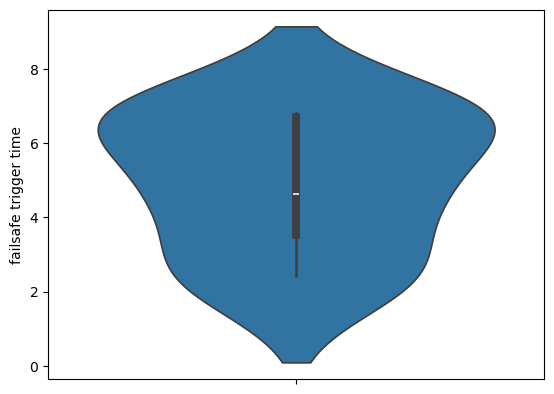

In [6]:
stale_data_distances, stale_data_distances_failsafe, stale_data_failsafes, stale_crashes, stale_recovered, stale_failsafe_times, stale_crash_times, stale_failsafe_mean, stale_failsafe_std, stale_crash_mean, stale_crash_std, stale_mean, stale_std, stale_max_mean,stale_max_std, stale_mean_f, stale_std_f,  stale_max_max_f, stale_max_min_f, stale_max_mean_f,stale_max_std_f = data_analysis(stale_data_traces_dict)
results = add_line_to_results_df(results, 'Stale', stale_data_failsafes, stale_crashes, stale_recovered, stale_failsafe_mean, stale_failsafe_std, stale_crash_mean, stale_crash_std,stale_mean, stale_std, stale_max_mean,stale_max_std, stale_mean_f, stale_std_f, stale_max_max_f, stale_max_min_f, stale_max_mean_f,stale_max_std_f)

In [7]:
# BMI270_data_traces_dict = load_attack_traces(data_folder+default_data+'/BMI270')
# # BMI270_data_traces_dict = transform_traces(BMI270_data_traces_dict)
# #BMI270_distances = compute_distances_and_describe_traces(average_position_df,BMI270_data_traces_dict)
# BMI270_distances, BMI270_distances_failsafe, BMI270_failsafes, BMI270_crashes, BMI270_recovered, BMI270_failsafe_times, BMI270_crash_times, BMI270_failsafe_mean, BMI270_failsafe_std, BMI270_crash_mean, BMI270_crash_std, BMI270_mean, BMI270_std, BMI270_max_mean,BMI270_max_std, BMI270_mean_f, BMI270_std_f, BMI270_max_max_f,BMI270_max_min_f, BMI270_max_mean_f,BMI270_max_std_f = data_analysis(BMI270_data_traces_dict)
# results = add_line_to_results_df(results, 'Default_BMI', BMI270_failsafes, BMI270_crashes, BMI270_recovered,BMI270_failsafe_mean, BMI270_failsafe_std, BMI270_crash_mean, BMI270_crash_std, BMI270_mean, BMI270_std, BMI270_max_mean,BMI270_max_std, BMI270_mean_f, BMI270_std_f, BMI270_max_max_f,BMI270_max_min_f, BMI270_max_mean_f,BMI270_max_std_f)

11 11 0 [1.223677, 1.223677, 1.223677, 1.223677, 1.223677, 1.223677, 1.223677, 1.223677, 1.223677, 1.223677, 1.223677] [4.559009, 4.559842, 4.559009, 4.554844, 4.5573429999999995, 4.559842, 4.563174, 4.556509999999999, 4.552345, 4.563174, 4.556509999999999]


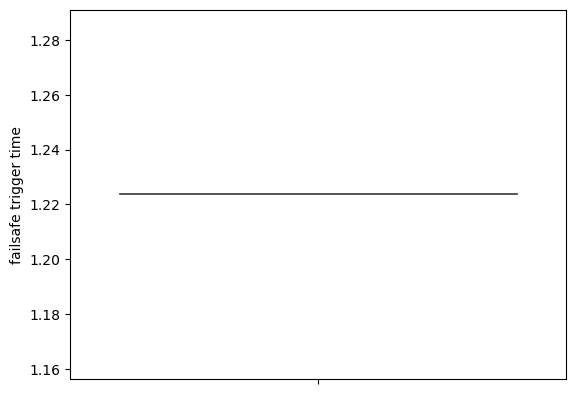

In [8]:
Invensense_data_traces_dict = load_attack_traces(data_folder+default_data+'/Invensense')
Invensense_distances, invensense_distances_failsafe, invensense_failsafes, invensense_crashes, invensense_recovered, invensesne_failsafe_times, invensense_crash_times, invensense_failsafe_mean, invensense_failsafe_std, invensense_crash_mean, invensense_crash_std, Invensense_mean, Invensense_std, Invensense_max_mean,Invensense_max_std, Invensense_mean_f, Invensense_std_f, Invensense_max_max_f,Invensense_max_min_f, Invensense_max_mean_f,Invensense_max_std_f = data_analysis(Invensense_data_traces_dict)
results = add_line_to_results_df(results, 'Default', invensense_failsafes, invensense_crashes, invensense_recovered,invensense_failsafe_mean, invensense_failsafe_std, invensense_crash_mean, invensense_crash_std, Invensense_mean, Invensense_std, Invensense_max_mean,Invensense_max_std, Invensense_mean_f, Invensense_std_f, Invensense_max_max_f,Invensense_max_min_f, Invensense_max_mean_f,Invensense_max_std_f)

In [9]:

# print(Invensense_mean)
# print(Invensense_std)
# print(Invensense_max_mean)
# print(Invensense_max_std)

# print('---cusum failsafe---')
# print(Invensense_mean_f)
# print(Invensense_std_f)
# print(Invensense_max_mean_f)
# print(Invensense_max_std_f)
# print(invensense_failsafes)

In [10]:
# Erroneous_data_traces_dict = load_attack_traces(data_folder+erroneous_data)
# Erroneous_distances, Erroneous_distances_failsafe, Erroneous_failsafes, erroneous_crashes, erroneous_recovered, erroneous_failsafe_times, erroneous_crash_times, erroneous_failsafe_mean, erroneous_failsafe_std, erroneous_crash_mean, erroneous_crash_std, erroneous_mean, erroneous_std, erroneous_max_mean,erroneous_max_std, erroneous_mean_f, erroneous_std_f, erroneous_max_max_f, erroneous_max_min_f, erroneous_max_mean_f,erroneous_max_std_f = data_analysis(Erroneous_data_traces_dict)
# results = add_line_to_results_df(results, 'Erroneous', Erroneous_failsafes, erroneous_crashes, erroneous_recovered, erroneous_failsafe_mean, erroneous_failsafe_std, erroneous_crash_mean, erroneous_crash_std, erroneous_mean, erroneous_std, erroneous_max_mean, erroneous_max_std, erroneous_mean_f, erroneous_std_f, erroneous_max_max_f, erroneous_max_min_f, erroneous_max_mean_f,erroneous_max_std_f)

In [11]:
# print(erroneous_mean)
# print(erroneous_std)
# print(erroneous_max_mean)
# print(erroneous_max_std)


# print('---cumsum failsafe---')
# print(erroneous_mean_f)
# print(erroneous_mean_f)
# print(erroneous_max_mean_f)
# print(erroneous_max_std_f)

# print(Erroneous_failsafes)
# print(erroneous_crashes, erroneous_recovered)

0 11 0 [] [4.202485, 4.216646, 4.22331, 4.219978, 4.22331, 4.219978, 4.2041509999999995, 4.226642, 4.219978, 4.216646, 4.224976]


/tmp/ipykernel_22244/3710748735.py:80: RuntimeWarning: Mean of empty slice.
  return np.array(time_vector).mean(), np.array(time_vector).std()
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/alessandro/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


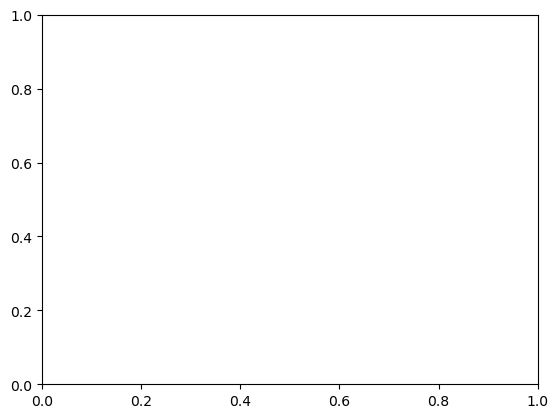

In [12]:
absent_data_150hz_traces_dict = load_attack_traces(data_folder+absent_data+'/150Hz')
absent_150hz_distances, absent_150hz_distances_failsafe, absent_150hz_failsafes, absent_150hz_crashes, absent_150hz_recovered, absent_failsafe_times, absent_crash_times, absent_150hz_failsafe_mean, absent_150hz_failsafe_std, absent_150hz_crash_mean, absent_150hz_crash_std, absent_150hz_mean, absent_150hz_std, absent_150hz_max_mean, absent_150hz_max_std, absent_150hz_mean_f, absent_150hz_std_f, absent_150hz_max_max_f, absent_150hz_max_min_f, absent_150hz_max_mean_f, absent_150hz_max_std_f = data_analysis(absent_data_150hz_traces_dict)
results = add_line_to_results_df(results, 'Absent',absent_150hz_failsafes, absent_150hz_crashes, absent_150hz_recovered, absent_150hz_failsafe_mean, absent_150hz_failsafe_std, absent_150hz_crash_mean, absent_150hz_crash_std, absent_150hz_mean, absent_150hz_std, absent_150hz_max_mean, absent_150hz_max_std, absent_150hz_mean_f, absent_150hz_std_f, absent_150hz_max_max_f, absent_150hz_max_min_f, absent_150hz_max_mean_f, absent_150hz_max_std_f)

In [18]:
results_paper = results[['failsafes', 'crashes', 'recovered', 'failsafe_mean', 'failsafe_std', 'crash_mean', 'crash_std',
                                'dist_max_max_fx', #'dist_max_min_fx',
                                #'dist_max_mean_fx', 
                             'dist_max_std_fx',
                                'dist_max_max_fy', #'dist_max_min_fy',
                                #'dist_max_mean_fy', 
                             'dist_max_std_fy',
                                'dist_max_max_fz', #'dist_max_min_fz',
                                #'dist_max_mean_fz', 
                         'dist_max_std_fz',
                              #   'maxx', 'stdmaxx',
                              #   'maxy', 'stdmaxy',
                              #   'maxz', 'stdmaxz',
                                ]]
results_paper_tab3 = results[['failsafes', 'crashes', 'recovered', 'failsafe_mean', 'failsafe_std', 'crash_mean', 'crash_std']]#'dist_max_max_fx', 'dist_max_min_fx',
results_paper_tab4 = results[['dist_max_mean_fx', 'dist_max_std_fx',
                                #'dist_max_max_fy', 'dist_max_min_fy',
                                'dist_max_mean_fy', 'dist_max_std_fy',
                                #'dist_max_max_fz', 'dist_max_min_fz',
                                'dist_max_mean_fz', 'dist_max_std_fz',
                                ]]

# Table 3 and 4

In [19]:
print(results_paper_tab3.style.format(decimal='.', precision=2).to_latex())

\begin{tabular}{lrrrrrrr}
 & failsafes & crashes & recovered & failsafe_mean & failsafe_std & crash_mean & crash_std \\
Stale & 100.00 & 0.00 & 100.00 & 4.99 & 1.80 & nan & nan \\
Default & 100.00 & 100.00 & 0.00 & 1.22 & 0.00 & 4.56 & 0.00 \\
Absent & 0.00 & 100.00 & 0.00 & nan & nan & 4.22 & 0.01 \\
\end{tabular}



In [22]:
print(results_paper_tab4.style.format(decimal='.', precision=2).to_latex())

\begin{tabular}{lrrrrrr}
 & dist_max_mean_fx & dist_max_std_fx & dist_max_mean_fy & dist_max_std_fy & dist_max_mean_fz & dist_max_std_fz \\
Stale & 16.67 & 15.82 & 7.60 & 7.86 & 1.24 & 1.17 \\
Default & 4.30 & 0.22 & 39.65 & 0.00 & 4.86 & 0.01 \\
Absent & 57.72 & 0.38 & 138.13 & 0.01 & 53.10 & 0.02 \\
\end{tabular}



In [15]:
plot(average_position_df,stale_data_traces_dict, 'x','y')
plot(average_position_df,stale_data_traces_dict, 'x','Alt')
plot(average_position_df,stale_data_traces_dict, 'TimeUS','x')

In [16]:
plot(average_position_df,BMI270_data_traces_dict, 'x','y')
plot(average_position_df,BMI270_data_traces_dict, 'x','Alt')

NameError: name 'BMI270_data_traces_dict' is not defined

In [ ]:
plot(average_position_df,Invensense_data_traces_dict, 'x','y')
plot(average_position_df,Invensense_data_traces_dict, 'x','Alt')

In [ ]:
plot(average_position_df,Erroneous_data_traces_dict, 'x','y')
plot(average_position_df,Erroneous_data_traces_dict, 'x','Alt')

In [ ]:
plot(average_position_df,absent_data_150hz_traces_dict, 'x','y')
plot(average_position_df,absent_data_150hz_traces_dict, 'x','Alt')

In [ ]:
import plot_formatting as pfg

TIME_SCALE = 1_000_000
plot_all = False
baseline_df = average_position_df[::100]

fig3 = make_subplots(rows=3, cols=1,
                    shared_xaxes=True,
                    vertical_spacing = 0.02,
                    row_heights=[.33]*3)

average_traces_df = stale_data_traces_dict[straight+str(0)]['POS']
average_traces_df['x'] -= baseline_df['x']
average_traces_df['y'] -= baseline_df['y']
average_traces_df['Alt'] -= baseline_df['Alt']


for ix in numbers:
    this_df = stale_data_traces_dict[straight+str(ix)]['POS']
    if plot_all:
        fig3.add_trace(go.Scatter(x=this_df['TimeUS'][::100]/TIME_SCALE, y=this_df['x'][::100]-baseline_df['x'],
                                        mode='lines+markers',
                                        name= str(ix)),
                                        row=1,col=1
                    )
        
        fig3.add_trace(go.Scatter(x=this_df['TimeUS'][::100]/TIME_SCALE, y=this_df['y'][::100]-baseline_df['y'],
                                        mode='lines+markers',
                                        name= str(ix)),
                                        row=2,col=1
                    )
        
        fig3.add_trace(go.Scatter(x=this_df['TimeUS'][::100]/TIME_SCALE, y=this_df['Alt'][::100]-baseline_df['Alt'],
                                        mode='lines+markers',
                                        name= str(ix)),
                                        row=3,col=1
                    )
        
    if ix > 0:
        average_traces_df['x'] += (this_df['x']-baseline_df['x'])
        average_traces_df['y'] += (this_df['y']-baseline_df['y'])
        average_traces_df['Alt'] += (this_df['Alt']-baseline_df['Alt'])
        
if not plot_all:
    average_traces_df['x']/len(numbers)
    average_traces_df['y']/len(numbers)
    average_traces_df['Alt']/len(numbers)
    fig3.add_trace(go.Scatter(x=this_df['TimeUS'][::100]/TIME_SCALE, y=average_traces_df['x'][::100],
                                        mode='lines+markers',
                                        name= str(ix)),
                                        row=1,col=1
                    )
        
    fig3.add_trace(go.Scatter(x=this_df['TimeUS'][::100]/TIME_SCALE, y=average_traces_df['y'][::100],
                                        mode='lines+markers',
                                        name= str(ix)),
                                        row=2,col=1
                    )
        
    fig3.add_trace(go.Scatter(x=this_df['TimeUS'][::100]/TIME_SCALE, y=average_traces_df['Alt'][::100],
                                        mode='lines+markers',
                                        name= str(ix)),
                                        row=3,col=1
                    )
    
fig3 = pfg.beautify_plot(fig3)
title_size=40
text_size=18
fig3['layout'].update(width=800, height=800, font=dict(size=text_size))

subplot_titles=['value', 'data rate', 'freq'],

#  Formating x-axis
fig3['layout']['xaxis3'].update(title='Time [s]', mirror=True)

# Formating y-axis
fig3['layout']['yaxis1'].update(title='delta x [m]')
fig3['layout']['yaxis2'].update(title='delta y [m]')
fig3['layout']['yaxis3'].update(title='delta Altitude [m]')

# fig3['layout']['legend'].update(orientation='h',
#                                 x=0.6,
#                                 y=0.2,
#                                    )

fig3.show()


In [ ]:
#compute the average detection time between attack start and crash and attack start and failsafe
Invensense_data_traces_dict['straight0']['MSG']['TimeUS']

121   102964631.0000
122   102969629.0000
133   104964664.0000
134   104972161.0000
140   106299963.0000
141   106309126.0000
Name: TimeUS, dtype: float64

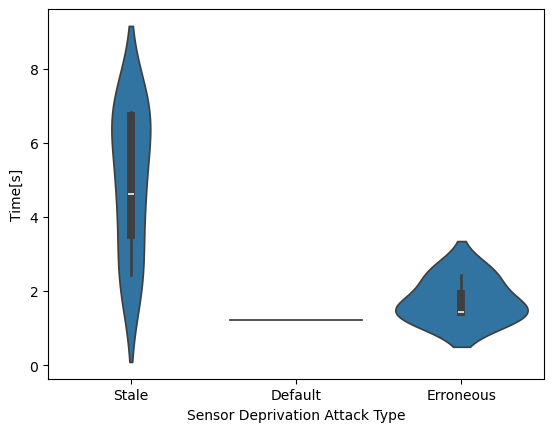

In [ ]:
#df = pd.DataFrame(columns= ['time', 'Sensor Deprivation Attack Type'] )
import matplotlib.pyplot as plt
d = {'Time[s]': stale_failsafe_times, 'Sensor Deprivation Attack Type': ['Stale']*len(stale_failsafe_times)}
df = pd.DataFrame(data=d)

xtra = {'Time[s]': invensesne_failsafe_times, 'Sensor Deprivation Attack Type': ['Default']*len(invensesne_failsafe_times)}

df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)

xtra = {'Time[s]': erroneous_failsafe_times, 'Sensor Deprivation Attack Type': ['Erroneous']*len(erroneous_failsafe_times)}

df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)

xtra = {'Time[s]': absent_failsafe_times, 'Sensor Deprivation Attack Type': ['Absent']*len(absent_failsafe_times)}
df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)
ax = sns.violinplot(data=df, y="Time[s]", x="Sensor Deprivation Attack Type")
fig = ax.get_figure()
plt.savefig("time_to_detect.pdf")

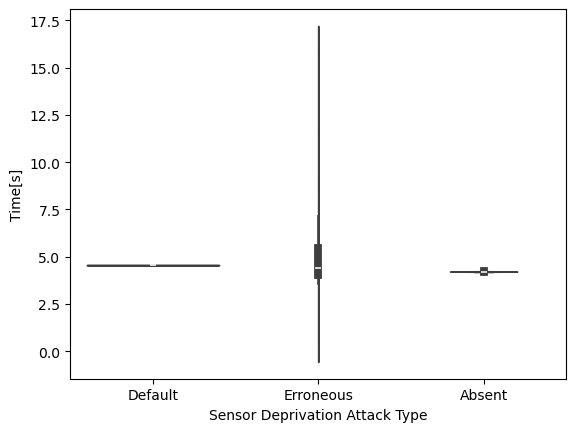

In [ ]:
d = {'Time[s]': stale_crash_times, 'Sensor Deprivation Attack Type': ['Stale']*len(stale_crash_times)}
df = pd.DataFrame(data=d)

xtra = {'Time[s]': invensense_crash_times, 'Sensor Deprivation Attack Type': ['Default']*len(invensense_crash_times)}

df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)

xtra = {'Time[s]': erroneous_crash_times, 'Sensor Deprivation Attack Type': ['Erroneous']*len(erroneous_crash_times)}

df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)

xtra = {'Time[s]': absent_crash_times, 'Sensor Deprivation Attack Type': ['Absent']*len(absent_crash_times)}

df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)
ax = sns.violinplot(data=df, y="Time[s]", x="Sensor Deprivation Attack Type")
fig = ax.get_figure()
plt.savefig("time_to_crash.pdf")

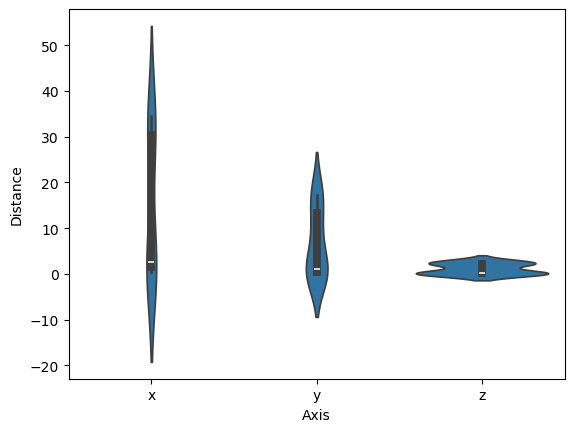

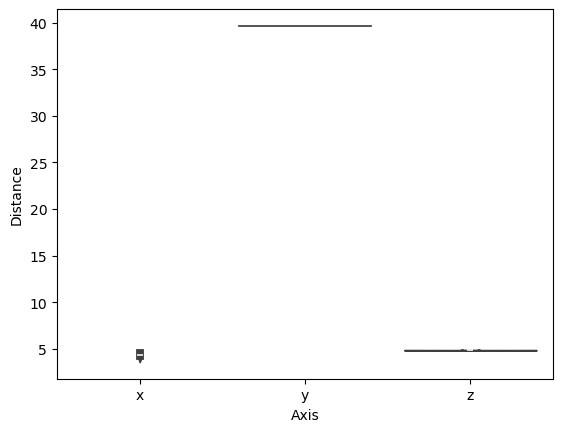

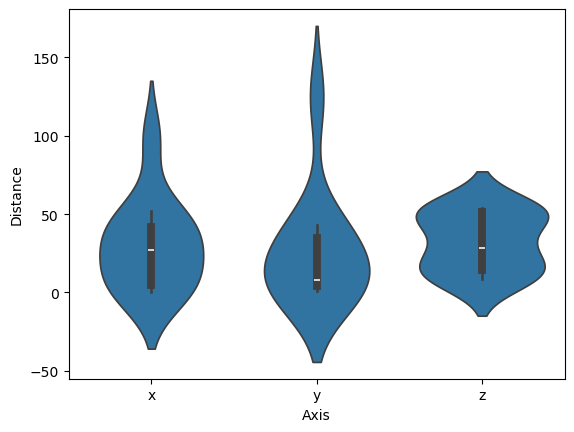

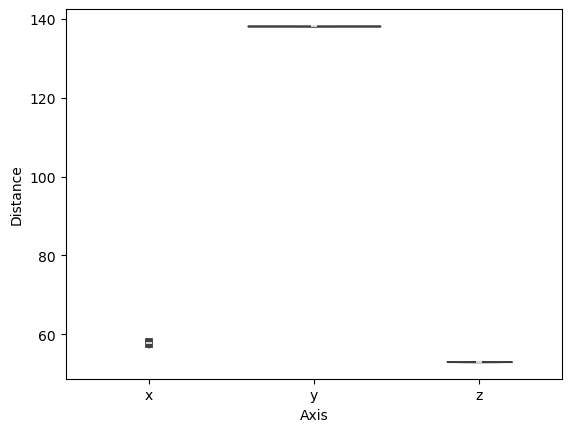

In [ ]:
count = 0
for dic in [stale_data_distances_failsafe, invensense_distances_failsafe, Erroneous_distances_failsafe, absent_150hz_distances_failsafe]:
    d = {'Distance':[], 'Axis': []}
    df = pd.DataFrame(data=d)
    for i in dic.keys():
        xtra = {'Distance': dic[i]['x'].max(), 'Axis': ['x']}
        df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)

        xtra = {'Distance': dic[i]['y'].max(), 'Axis': ['y']}

        df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)

        xtra = {'Distance': dic[i]['Alt'].max(), 'Axis': ['z']}

        df = pd.concat([df, pd.DataFrame(xtra)], ignore_index=True)
    
    plt.figure()
    sns.violinplot(data=df, y="Distance", x="Axis")   
        
#         fig = ax.get_figure()
#         plt.savefig("fig"+str(count)+".pdf")
    count += 1